In [1]:
conda_script='source /Users/ruijiangfu/miniconda3/etc/profile.d/conda.sh; conda activate MethylTree'

In [2]:
import methscan
from methscan import matrix
from methscan import prepare
from methscan import profile

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import methyltree 
from tqdm import tqdm
import scipy.stats as stats
import scanpy as sc
import cospar as cs
import yaml
from matplotlib import cbook, cm, colors, rcParams
from datetime import datetime, timedelta
sns.set_style('white')
rcParams["axes.spines.right"] = False
rcParams["axes.spines.top"] = False
rcParams["font.size"] = 13
# %config InlineBackend.figure_format = 'svg' #'retina'         # or 'svg'
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10)

cs.settings.set_figure_params()

In [3]:
current_directory = os.getcwd()

data_path=f'{current_directory}/metadata/mouse_LK_all/downstream_R/all_data'
df_sample=methyltree.metadata.update_samples_from_config(data_path)

with open(f'{data_path}/../../config.yaml', 'r') as yaml_file:
    yaml_data = yaml.safe_load(yaml_file)
    if 'reference' not in yaml_data['bismark']:
        genome_reference='mm10'
    else:
        genome_reference=yaml_data['bismark']['reference']
        
    if genome_reference=='mm10':
        profile_annotation='prom_2000_2000'
        ref_prefix=''
    else:
        ref_prefix=f'{genome_reference}_'
        profile_annotation=f'{genome_reference}_prom_2000_2000'
    print(f'Genome reference: {genome_reference}')

Initialize sample info
old_samples: 576; config samples: 576; merged samples: 576
Genome reference: mm10


# Fast matrix generation with MethScan

In [4]:
out_dir=f'{data_path}/out_dir'
methscan_data_dir=f'{data_path}/methscan'
compact_file_dir=f'{out_dir}/compact_data'

## Generate compact data for fast access 
(need to be done only once, regardless of which annotation you use)

In [5]:
#selected_sample_list=list(df_sample['sample'].unique())
selected_sample_list=[x.split('.tsv.gz')[0] for x in os.listdir(f'{data_path}/met/cpg_level') if '.gz' in x]
len(selected_sample_list)
print(f"{datetime.now()} (hour:min:s).\n")

2024-11-19 11:54:49.907303 (hour:min:s).



In [6]:
input_files=[f'{data_path}/met/cpg_level/{x}.tsv.gz' for x in selected_sample_list]
recompute=False
# compact the data
if (not os.path.exists(f'{compact_file_dir}/chr1.npz')) or recompute:
    methscan.prepare.prepare(input_files,compact_file_dir,input_format='1:2:3:4u:\t:1',round_sites=True,chunksize=1e7)
    # smooth the data (we do not need this, but this is required by this package)
    methscan.smooth.smooth(compact_file_dir,bandwidth=1000, use_weights=True)
    
if os.path.exists(f'{compact_file_dir}/1.npz'):
    raise ValueError('chromosome name in cpg_level files should be changed to chr1 format')

## Generate the cell-by-region matrix (Run Section2 of the MethScan_notebook in the MethScan environment.)

In [7]:
methscan_data_dir=f'{data_path}/methscan'
method='bulk'
annotation='neutral_thresh_mouse_LK_readNcutoff_3_0.1_0.6_500bp'
matrix_dir=f'{methscan_data_dir}/matrix/{annotation}'
print(f"{datetime.now()} (hour:min:s).\n")

2024-11-19 11:54:49.912686 (hour:min:s).



In [8]:
region_dir=f"{current_directory}/metadata/mouse_LK_all/bed_files/{annotation}.bed"
recompute=False
with open(region_dir,'r') as regions:
    if (not os.path.exists(f'{matrix_dir}/matrix.mtx.gz')) or recompute:
        methscan.matrix.matrix_sparse(compact_file_dir, regions, matrix_dir, threads=-1)

## Generate the adata

In [9]:
read_cutoff=1
exclude_sex=0
min_coverage=2
groupby='tissue'
selected='LK'
save_data_des=f'{groupby}_{selected}_{annotation}_readcutoff{read_cutoff}_minCov{min_coverage}_met_ExcludeSex{exclude_sex}'

In [10]:
## load the full data
print(f"{datetime.now()} (hour:min:s).\n")
df_data=methyltree.adata.load_methscan_matrix(matrix_dir)

2024-11-19 11:54:49.920827 (hour:min:s).



In [11]:
## select a subset of cells
sample_index_map=methyltree.metadata.get_methscan_sample_index_map(compact_file_dir)
selected_row=df_sample[(df_sample[groupby]==selected) & df_sample['HQ']]['sample'].map(sample_index_map).to_list()
df_data_sub=df_data[df_data['row'].isin(selected_row)]

In [12]:
adata=methyltree.adata.generate_adata_from_methscan_matrix(df_data_sub,matrix_dir,read_cutoff=read_cutoff)
methyltree.hf.update_sample_info_on_adata(adata,df_sample)
adata=methyltree.adata.filter_adata(adata,exclude_sex=exclude_sex,exclude_chrM=True,min_cell_coverage=min_coverage)
print(f"{datetime.now()} (hour:min:s).\n")

full adata shape: (539, 277530)
adata shape removing regions covering less than 2 cells : (539, 277184)
2024-11-19 11:55:03.408840 (hour:min:s).



In [13]:
adata

View of AnnData object with n_obs × n_vars = 539 × 277184
    obs: 'id_rna', 'cell', 'pass_accQC', 'pass_metQC', 'id_met', 'id_acc', 'lineage', 'stage', 'nCG', 'n_meth', 'met_rate', 'TSS_score', 'plate', 'HQ', 'plate_id', 'chrM_rate', 'CpG_rate', 'CHG_rate', 'CHH_rate', 'Mapping_efficiency', 'tissue', 'plate_barcode', 'Lime_barcode', 'celltype', 'UMAP_rna_x', 'UMAP_rna_y', 'clone_id'

## Optional: add RNA and LARRY infomation in df_sample

In [14]:
adata_RNA_LARRY = sc.read(f'{current_directory}/metadata/mouse_LK_all/RNA_and_LARRY/mouse_LK_RNA_and_LARRY.h5ad')

In [15]:
df_sample['plate_barcode']=df_sample['sample'].apply(lambda x: x.split('_')[-1])

In [16]:
Lime_barcode = methyltree.metadata.mapping_from_plate_barcode_to_Lime_barcode(
    df_sample["plate_barcode"]
)

df_sample["Lime_barcode"] = Lime_barcode

In [17]:
def assign_id_rna(row):
    if row['cell'].startswith('LK_DNA_1_'):
        return 'LK_RNA_1_' + row['Lime_barcode']
    elif row['cell'].startswith('LK_DNA_2_'):
        return 'LK_RNA_2_' + row['Lime_barcode']
    elif row['cell'].startswith('LK_DNA_3_'):
        return 'LK_RNA_3_' + row['Lime_barcode']
    elif row['cell'].startswith('LK_DNA_4_'):
        return 'LK_RNA_4_' + row['Lime_barcode']
    elif row['cell'].startswith('LK_DNA_5_'):
        return 'LK_RNA_5_' + row['Lime_barcode']
    else:
        return 'LK_RNA_6_' + row['Lime_barcode']

df_sample['id_rna'] = df_sample.apply(assign_id_rna, axis=1)

In [18]:
df_clone_fate=cs.tl.clone_statistics(adata_RNA_LARRY,joint_variable='state_info',
    display_clone_stat=True,)
df_clone_fate

            clone_N  clone_fraction
state_info                         
Ba                9        0.120000
Ba,Er,nan         2        0.026667
Ba,Ma             3        0.040000
Ba,Neu            1        0.013333
Ba,Neu,Er         1        0.013333
...             ...             ...
Ma,Er             1        0.013333
Mk                5        0.066667
Mk,Ba,Er          1        0.013333
Mk,Er             6        0.080000
Neu               3        0.040000

[22 rows x 2 columns]
-----------
            cell_N  clonal_cell_fraction
state_info                              
Ba             183              0.347249
Dc-Mo           24              0.045541
Eos             15              0.028463
Er              79              0.149905
Ma              93              0.176471
Mk              35              0.066414
Neu             39              0.074004
Neu-Mo          25              0.047438
nan             34              0.064516


,clone_id,clone_size,state_info,state_info_N
0,0,56,Ba,1
1,1,10,"Mk,Er",2
2,2,1,Ma,1
3,3,1,Mk,1
4,4,2,Dc-Mo,1
...,...,...,...,...
70,70,4,"Mk,Er",2
71,71,2,Dc-Mo,1
72,72,2,Mk,1
73,73,15,"Eos,Mk,Neu,Er",4


In [19]:
cs.tl.add_clone_id_for_each_cell(adata_RNA_LARRY)

add information at obs['clone_id']


In [20]:
adata_rna_tmp = adata_RNA_LARRY[adata_RNA_LARRY.obs_names.isin(df_sample["id_rna"])]
df_sample = df_sample.set_index("id_rna")
df_UMAP = pd.DataFrame(
    {
        "id_rna": adata_rna_tmp.obs_names,
        "UMAP_rna_x": adata_rna_tmp.obsm["X_umap"][:, 0],
        "UMAP_rna_y": adata_rna_tmp.obsm["X_umap"][:, 1],
    }
).set_index("id_rna")
df_sample.loc[adata_rna_tmp.obs_names, "celltype"] = adata_rna_tmp.obs[
    "cell_type"
].astype(str)
df_sample.loc[adata_rna_tmp.obs_names, "UMAP_rna_x"] = df_UMAP["UMAP_rna_x"]
df_sample.loc[adata_rna_tmp.obs_names, "UMAP_rna_y"] = df_UMAP["UMAP_rna_y"]

In [21]:

def add_prefix(clone_id):
    if clone_id == '':
        return np.nan
    else:
        return 'clone_' + str(clone_id)

# 应用这个函数到 clone_id 列
df_sample.loc[adata_rna_tmp.obs_names, "clone_id"] = adata_rna_tmp.obs["clone_id"].apply(add_prefix)


In [22]:
df_sample=df_sample.reset_index()
methyltree.metadata.backup_and_save_sample_info(df_sample,data_path)

## MethylTree analysis

Perform additional filtering (min_coverage, exclude_sex) 

use provided adata
adata shape:  (539, 277184)
X_similarity_correlation_fast_raw not found in adata.obsm
re-compute similarity matrix
Use correlation_fast for similarity
-------zero centered--------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 539/539 [01:54<00:00,  4.70it/s]


duration: 117.92456889152527
correct similarity: outer loop 0;  current epsilon 0.05
Use fast/analytical correction method


  2%|███▏                                                                                                                                                          | 20/1000 [00:00<00:04, 236.80it/s]


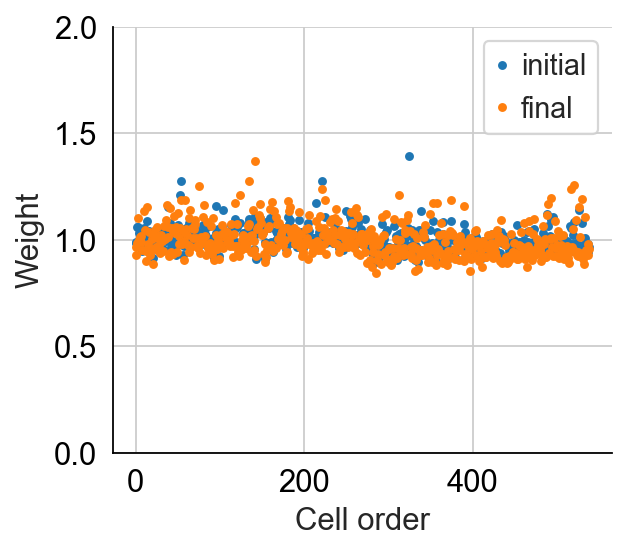

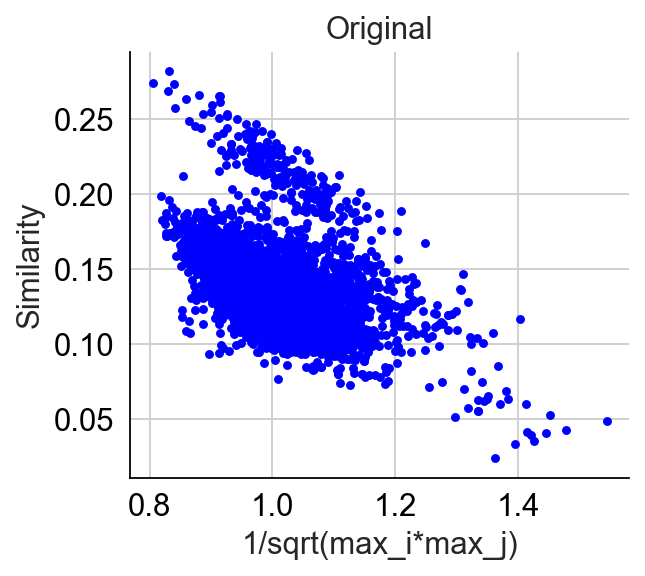

std: 0.019


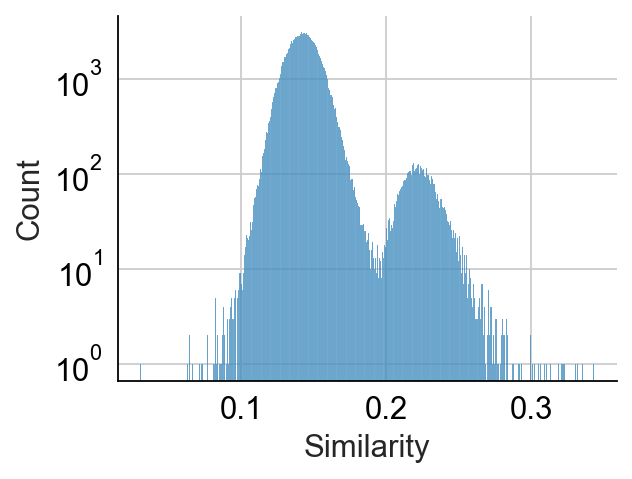

Reconstruction method: UPGMA
      clone  clone_size  accuracy  continuity  entropy  wassertein  \
0   clone_0          56       1.0         1.0      0.0         0.0   
1   clone_1          10       1.0         1.0      0.0         0.0   
2  clone_10           2       1.0         1.0      0.0         0.0   
3  clone_12           4       1.0         1.0      0.0         0.0   
4  clone_13           3       1.0         1.0      0.0         0.0   

   random_accuracy  random_continuity  random_entropy  random_wassertein  
0         0.039286           0.117857        0.964865           0.782143  
1         0.020000           0.110000        0.993979           0.800000  
2         0.000000           0.500000        1.000000           0.500000  
3         0.050000           0.275000        0.975000           0.725000  
4         0.000000           0.333333        1.000000           0.666667  
mean continuity: 1.0
mean accuracy: 1.0
mean entropy: 0.0
mean wassertein: 0.0
mean random_continuit

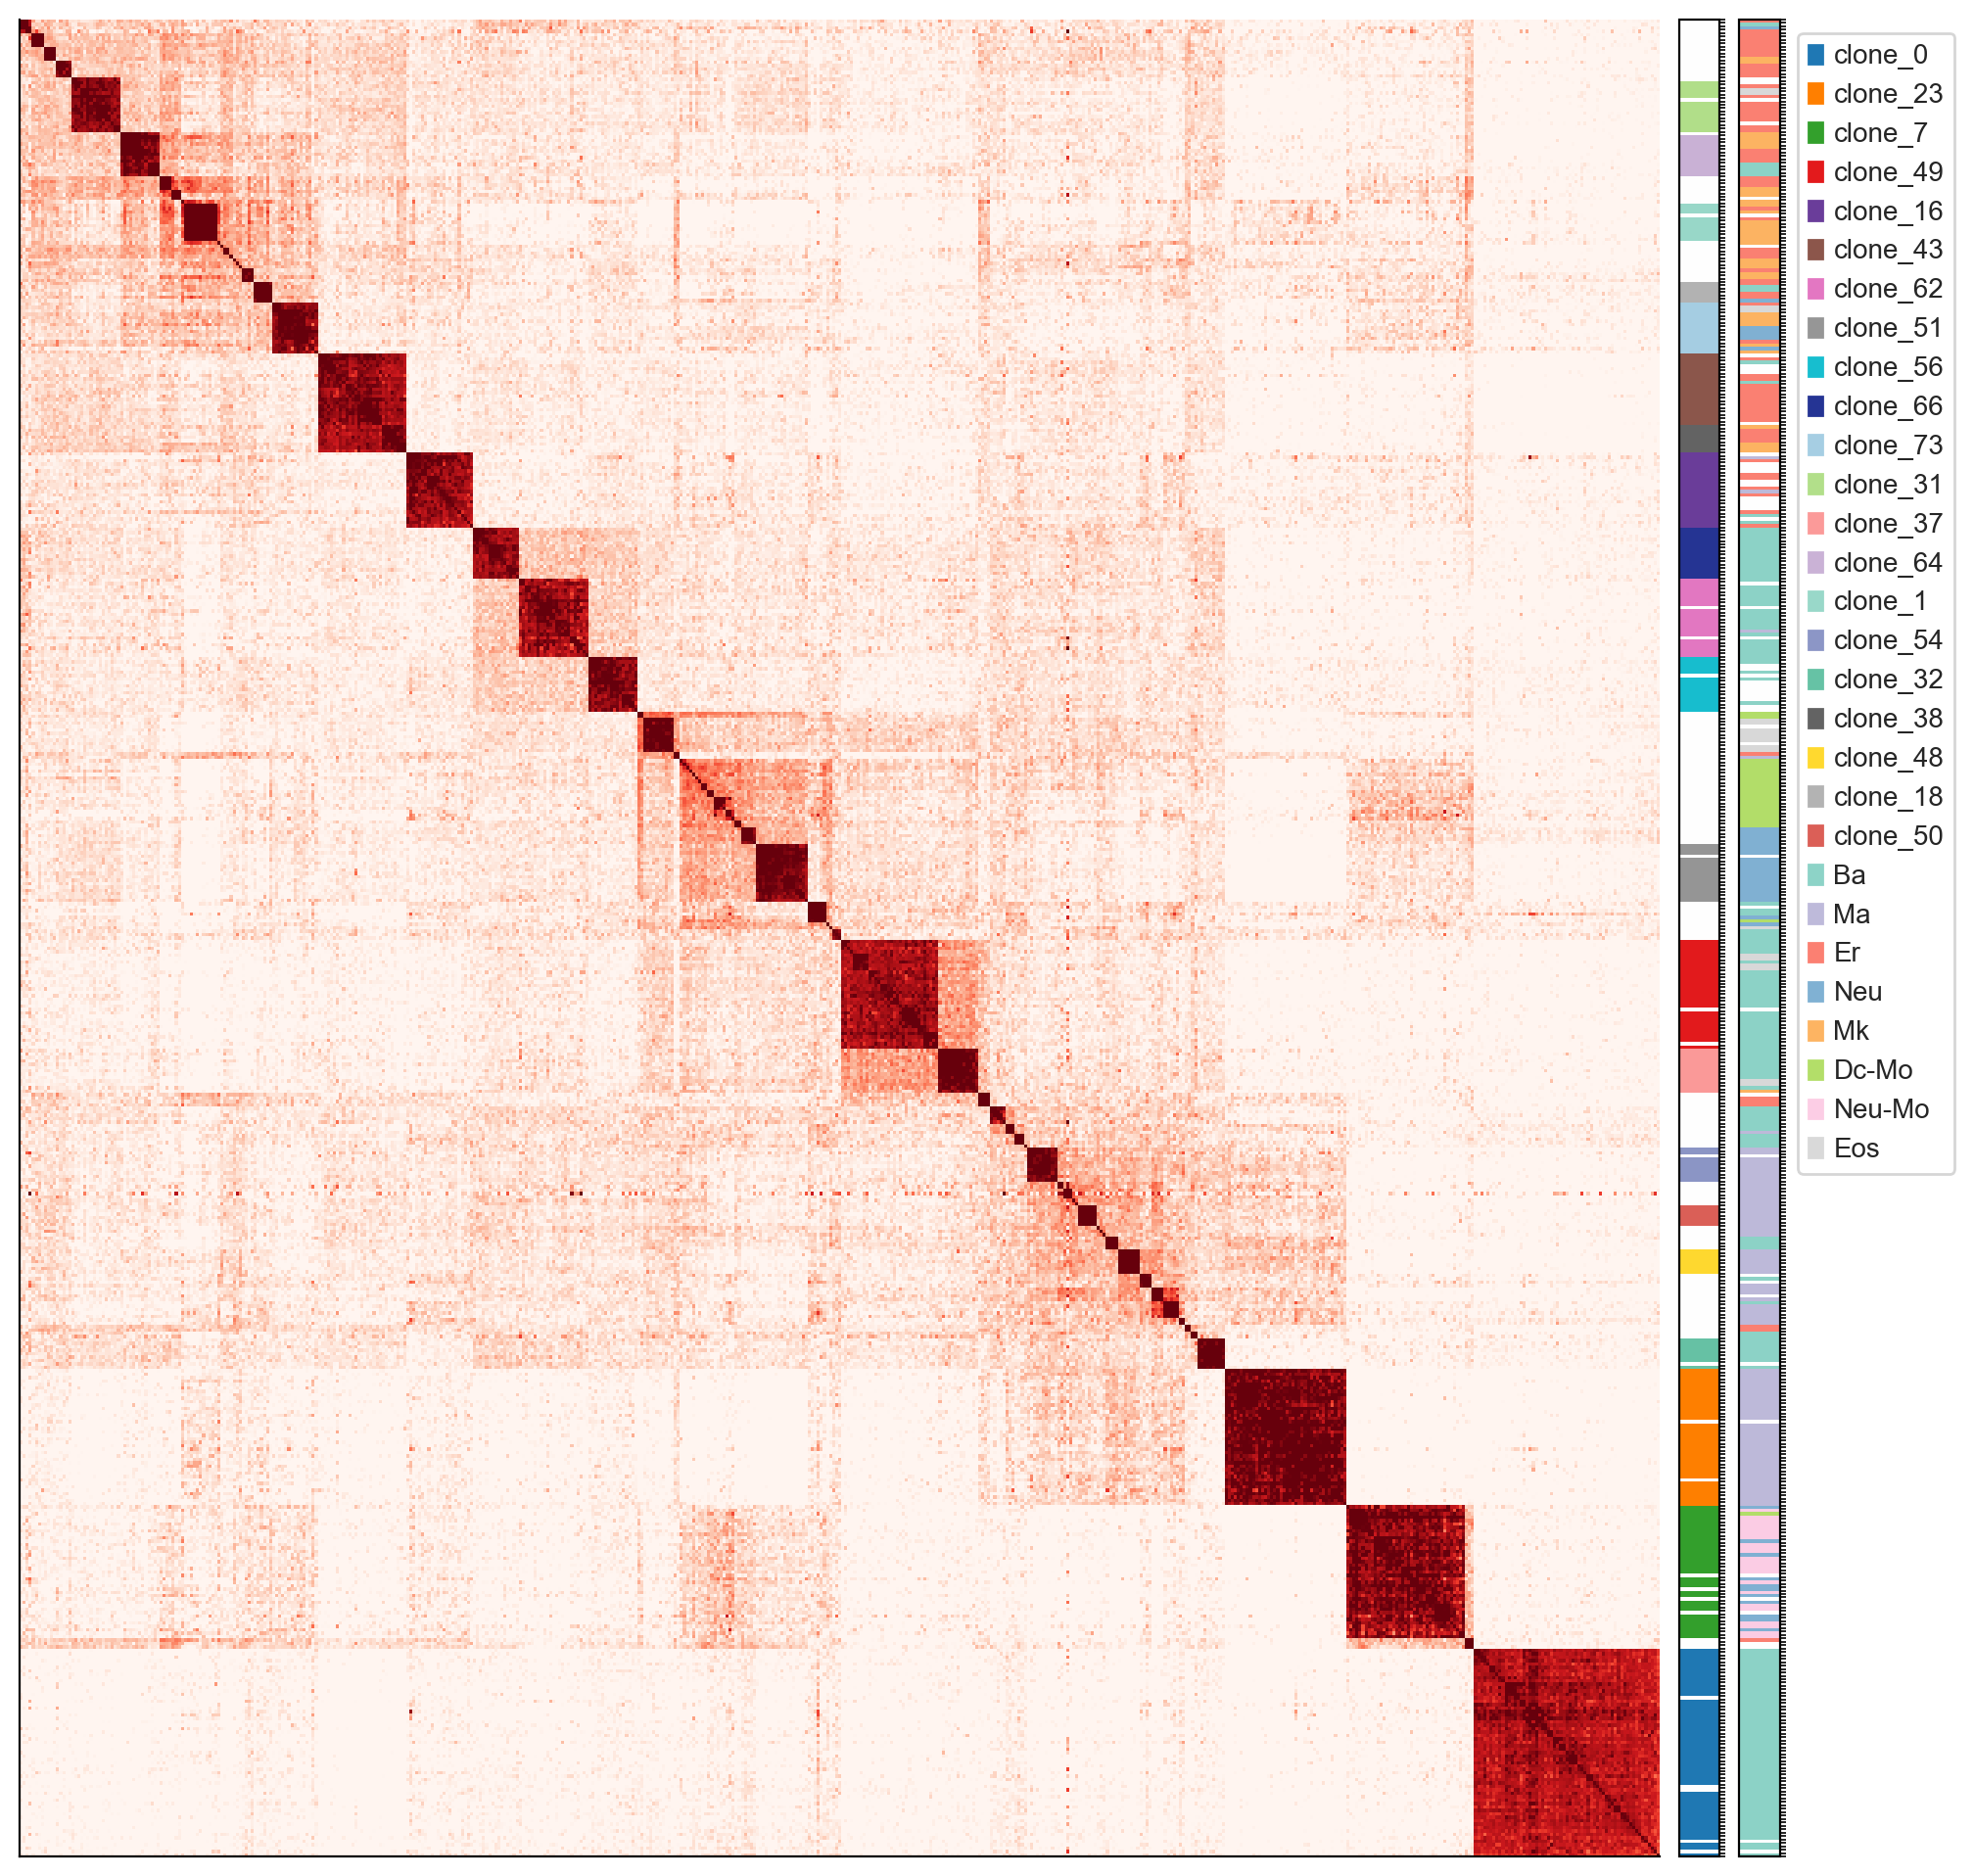

In [23]:
adata, statu_out = methyltree.analysis.comprehensive_lineage_analysis(
    out_dir,
    data_path,
    save_data_des=None,
    clone_key='clone_id',
    adata_orig=adata,
    compute_similarity=False,  # use pre-computed similarity
    similarity_method='correlation_fast',
    remove_celltype_signal=False,
    similarity_normalize=False,
    similarity_correction=True,
    perform_coarse_graining=False,
    fig_dir=None,
    heatmap_vmax_percentile=99.5,
    heatmap_vmin_percentile=40,
    heatmap_additional_key_list=['celltype']
)


# Generating your own bed region file

This require you to install R and related packages. 

## Pseudo bulk

In [24]:
group_by_key='tissue'

In [25]:
df_sample[group_by_key].unique()

array(['LK'], dtype=object)

In [26]:
for class_tmp in df_sample[group_by_key].unique():
    print(class_tmp)
    for source in ['met']:
        # scenario: all, only_bulk, only_bigwig
        script_name=methyltree.scripts.generate_script_bulk_bigwig(data_path,source=source,min_cells=1,group_by=group_by_key,sample_list=[class_tmp],reference=genome_reference,scenario='only_bulk')
        command=f'{conda_script}; python {script_name}'
        print(command)
        
        ## you can choose to run in on this noteobok, or using SLURM
        os.system(command)
        # methyltree.scripts.run_sbatch(command,
        # sbatch_mode='amd-ep2', #'intel-sc3',
        # mem='20G',
        # cores=1,
        # time='2:00:0',
        # job_name=f'bw_{source}_{class_tmp}',)

LK
script scenario: only_bulk
source /Users/ruijiangfu/miniconda3/etc/profile.d/conda.sh; conda activate MethylTree; python /Users/ruijiangfu/Documents/Projects/MethyTree/MethylTree_dataset/MethylTtree_notebook/metadata/mouse_LK_all/downstream_R/all_data/scripts/generate_bulk_bigwig_met_tissue_LK.py
Fatal error: cannot open file 'pseudobulk/pseudobulk_metacc_SW.R': No such file or directory
/Users/ruijiangfu/Documents/Projects/MethyTree/MethylTree_dataset/MethylTtree_notebook/metadata/mouse_LK_all/downstream_R/all_data


sh: line 0: cd: ./Rscripts: No such file or directory


## Genomic window selection

In [27]:
import pyranges as pr

source='met'
selected_stage='LK' # Ideally, we should use all data
df_base_window = pd.read_csv(f'{current_directory}/metadata/mouse_LK_all/bed_files/{ref_prefix}500bp.bed',sep='\t',header=None, names=['Chromosome','Start','End','label','range','local'],skiprows=1).filter(['Chromosome','Start','End'])
df_bulk=pd.read_csv(f'{data_path}/{source}/cpg_level/pseudobulk/{group_by_key}/{selected_stage}.tsv.gz',sep='\t',compression='gzip').rename(columns={'chr':'Chromosome','pos':'Start'})

df_bulk['End']=df_bulk['Start']
df_bulk['total_N']=df_bulk['met_sites']+df_bulk['nonmet_sites']
df_bulk_v1=df_bulk.filter(['Chromosome','Start','End','met_sites','nonmet_sites','rate'])

df_base_window=df_base_window[~pd.isna(df_base_window['Start'])]
df_base_window['id']=df_base_window['Chromosome']+'_'+df_base_window['Start'].astype(str)+'_'+df_base_window['End'].astype(str)
df_intersect=pr.PyRanges(df_base_window).join(pr.PyRanges(df_bulk_v1)).as_df()

df_counts=df_intersect.groupby('id').agg({'met_sites':'sum','nonmet_sites':'sum','rate':'mean'}).reset_index()
df_intersect_2=df_intersect.filter(['Chromosome', 'Start', 'End', 'id']).drop_duplicates().merge(df_counts,on='id')
df_intersect_2['total_N']=df_intersect_2['met_sites']+df_intersect_2['nonmet_sites']

df_intersect_2['rate_new']=df_intersect_2['met_sites']/df_intersect_2['total_N']
df_intersect_2['rate']=df_intersect_2['rate']/100

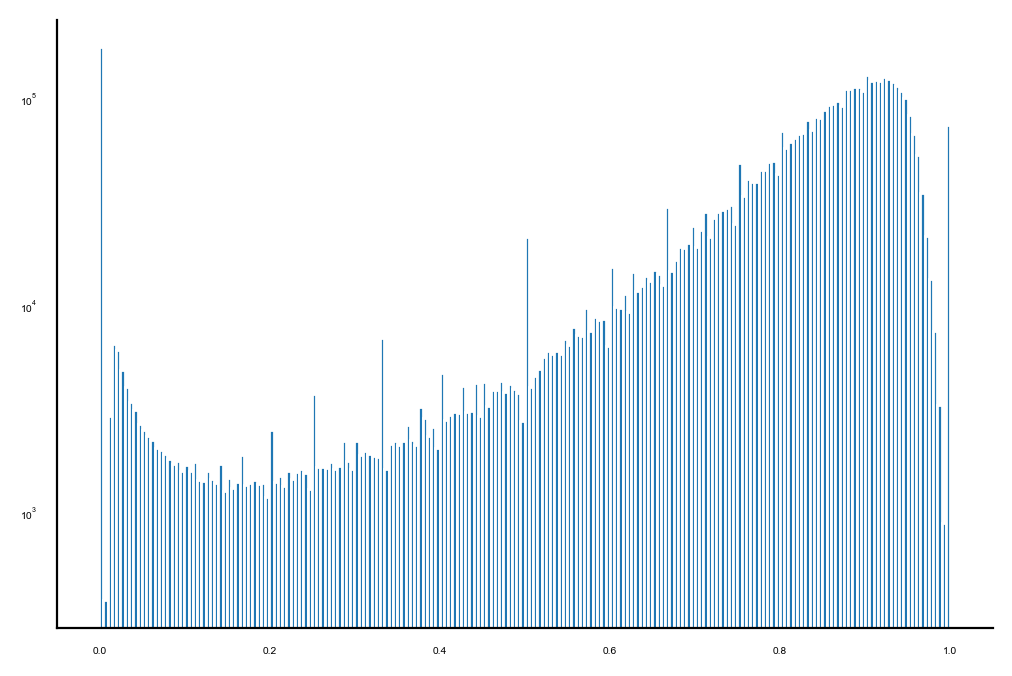

In [28]:
fig,ax=plt.subplots()
plt.hist(df_intersect_2['rate_new'],bins=200);
plt.yscale('log')

Text(0, 0.5, 'Window reads sum, Rate')

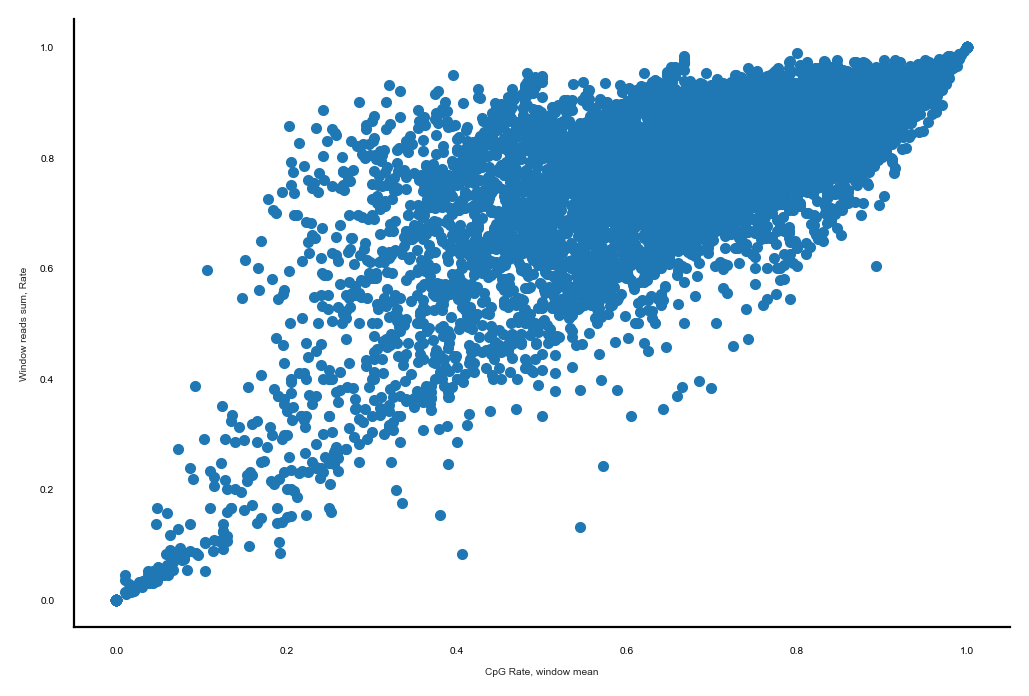

In [29]:
plt.plot(df_intersect_2['rate'][:10000],df_intersect_2['rate_new'][:10000],'.')
plt.xlabel('CpG Rate, window mean')
plt.ylabel('Window reads sum, Rate')

In [30]:
thresh_low = 0.1
thresh_high = 0.6
read_N_cutoff=3
annotation_name='mouse_LK' # This needs to be changed, dataset-specific
merge=True


print(f'------------- thresh_high = {thresh_high}, thresh_low = {thresh_low} -------------')

df_intersect_3=df_intersect_2[((df_intersect_2['rate_new']>=thresh_low) & (df_intersect_2['rate_new']<=thresh_high) & (df_intersect_2['total_N']>=read_N_cutoff))]
df_intersect_3['Start']=df_intersect_3['Start']-1

df_bed=methyltree.region.generate_feature_bed_file_from_signal_peaks(df_intersect_3,signal_key='rate_new',merge=merge,annotation_name=annotation_name)

print(f'length {len(df_bed)}')

final_annotation=f'neutral_thresh_{annotation_name}_readNcutoff_{read_N_cutoff}_{thresh_low}_{thresh_high}_500bp'
bed_dir=f"{current_directory}/metadata/mouse_LK_all/bed_files/{final_annotation}.bed"
print(f'Annotation name: {final_annotation}')

## Run this code to save the bed file
df_bed.to_csv(f"{bed_dir}", sep="\t", index=0, header=None)

------------- thresh_high = 0.6, thresh_low = 0.1 -------------
length 277530
Annotation name: neutral_thresh_mouse_LK_readNcutoff_3_0.1_0.6_500bp
